# Experiments on different prompts for decoder training

## Dataset loading

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

### Load dataset

Load the dataset with hugging face and split between train and test.

In [3]:
ds = load_dataset('json', data_files='/home/ubuntu/data/small_metadata.json')

train_dataset = ds["train"].filter(lambda example: example["split"] == "train")
val_dataset = ds["train"].filter(lambda example: example["split"] == "val")
del(ds)
print(f'Length of train dataset:', len(train_dataset))
print(f'Length of validation dataset', len(val_dataset))

Length of train dataset: 3379
Length of validation dataset 251


Define the local folder where the dataset is located.

In [4]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/"

Define the processor (encoder) of SAM.

In [5]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [6]:
from utils.sam_dataset import SAMDataset
sam_train_dataset = SAMDataset(dataset=train_dataset, processor=processor, data_folder=data_folder)
sam_val_dataset = SAMDataset(dataset=val_dataset, processor=processor, data_folder=data_folder)

In [7]:
item = sam_train_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'input_points', 'ground_truth_mask', 'original_image', 'gt_box'])


### Create PyTorch dataloader

In [8]:
from torch.utils.data import DataLoader

sam_train_dataloader = DataLoader(sam_train_dataset, batch_size=1, shuffle=True)
sam_val_dataloader = DataLoader(sam_val_dataset, batch_size=1, shuffle=True)

## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [9]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

### Train the model

In [16]:
from torch.optim import Adam
import monai
from utils.model_training import train_model

device = "cuda" if torch.cuda.is_available() else "cpu"

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=1e-4)
# Define loss
geom_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 1
# Define parameters for topological loss
topo_param = {'lamda': 0.1, 
              'interp': 50, 
              'feat_d': 1, 
              'loss_q': 2, 
              'loss_r': False}
# Run training function
for i in range(13, 16):
    train_model(model = model, prompt = "box", optimizer = optimizer, geometric_loss = geom_loss, 
                train_dataloader = sam_train_dataloader, val_dataloader=sam_val_dataloader, 
                num_epochs = num_epochs, device = device, geom_interp = 150,
                topological_loss = True, topo_param = topo_param)
    model_name = "/home/ubuntu/models/sam_experiments/topo-no-reg-lambda-0.1_geom-int150_box-prompt_ep-" + str(i) + ".pth"
    torch.save(model, model_name)
    

100%|██████████| 3379/3379 [29:46<00:00,  1.89it/s]


EPOCH: 1
Train dataset mean loss: 0.1003560779988876


100%|██████████| 251/251 [02:07<00:00,  1.97it/s]


Validation dataset mean loss: 0.14840763867406018


100%|██████████| 3379/3379 [29:37<00:00,  1.90it/s]


EPOCH: 1
Train dataset mean loss: 0.09944262888010225


100%|██████████| 251/251 [02:07<00:00,  1.97it/s]


Validation dataset mean loss: 0.14843453069132162


100%|██████████| 3379/3379 [29:44<00:00,  1.89it/s]


EPOCH: 1
Train dataset mean loss: 0.09777229841993959


100%|██████████| 251/251 [02:07<00:00,  1.97it/s]


Validation dataset mean loss: 0.139862050677082


In [16]:
case_1_train_loss = [0.208379, 0.169627, 0.153871, 0.148901, 0.139778, 0.136574, 0.133296, 0.129903, 0.127568, 0.123879, 0.122559, 0.120981, 0.117350, 0.115167, 0.115156]
case_1_val_loss = [0.194046, 0.181619, 0.175414, 0.167279, 0.158477, 0.162258, 0.156139, 0.159229, 0.159447, 0.153835, 0.164574, 0.157481, 0.165515, 0.146057, 0.1521126]
case_2_train_loss = [0.272679, 0.199611, 0.180806, 0.171409, 0.164641, 0.157219, 0.155375, 0.146513, 0.142123, 0.137923, 0.134436, 0.135501, 0.131146, 0.129399, 0.124954]
case_2_val_loss = [0.246064, 0.228632, 0.209754, 0.199193, 0.202144, 0.191142, 0.190719, 0.185964, 0.205826, 0.176417, 0.185357, 0.171031, 0.176258, 0.174036, 0.176917]
case_3_train_loss = [0.191003, 0.145116, 0.133745, 0.122715, 0.117432, 0.112824, 0.107166, 0.105859, 0.106329, 0.101336, 0.099127, 0.098851, 0.095615, 0.094015, 0.089879]
case_3_val_loss = [0.170964, 0.159436, 0.163678, 0.154976, 0.148447, 0.156134, 0.149631, 0.151427, 0.141092, 0.138918, 0.149186, 0.139226, 0.140601, 0.147948, 0.143565]
case_4_train_loss = [0.243093, 0.175259, 0.156619, 0.143798, 0.136520, 0.128965, 0.126603, 0.123102, 0.121179, 0.116352, 0.112472, 0.109109, 0.112735, 0.108070, 0.106040]
case_4_val_loss = [0.219260, 0.209367, 0.184754, 0.178854, 0.168810, 0.171555, 0.174698, 0.173599, 0.167553, 0.177013, 0.170981, 0.166561, 0.164811, 0.167652, 0.164475]

These are the losses for $\lambda = 0.01$. We will keep the model of epoch 12, since it is the best one so far. We have saved it here `/home/ubuntu/models/sam_experiments/topo-no-reg-lambda-0.01_geom-int150_box-prompt.pth`

In [12]:
case_1_train_loss = [0.192999, 0.145941, 0.131385, 0.125927, 0.119163, 0.113231, 0.112586, 0.109252, 0.106909, 0.1026, 0.101332, 0.096812, 0.096364, 0.09444, 0.092038]
case_1_val_loss = [0.171319, 0.171174, 0.161899, 0.155438, 0.158695, 0.151913, 0.147609, 0.151481, 0.1423, 0.1463, 0.141797, 0.141678, 0.1447027, 0.142067, 0.144392]

These are the losses for $\lambda = 0.1$. We will keep the model of epoch 15, since it is the best one so far. We have saved it here `/home/ubuntu/models/sam_experiments/topo-no-reg-lambda-0.1_geom-int150_box-prompt.pth`

In [17]:
case_1_train_loss = [0.199781, 0.152704, 0.139115, 0.130058, 0.122876, 0.117326, 0.114431, 0.112403, 0.110124, 0.109209, 0.103794, 0.103095, 0.100305, 0.099443, 0.097772]
case_1_val_loss = [0.178758, 0.167301, 0.163163, 0.156672, 0.151552, 0.160246, 0.154067, 0.148974, 0.149704, 0.150558, 0.142496, 0.149875, 0.148407, 0.148434, 0.139862]

### SAM trained with Topological loss (without regularisation) with interpolation of 50, geometrical loss with interpolation of 150 and box prompt

The training takes around 32min per epoch. Weight decay was `weight_decay = 1e-4` and learning rate was `lr = 1e-5`. We have used batch size 1.

Right we have trained the model for 15 epochs, and the best one was the 14th.

Let us plot the results.

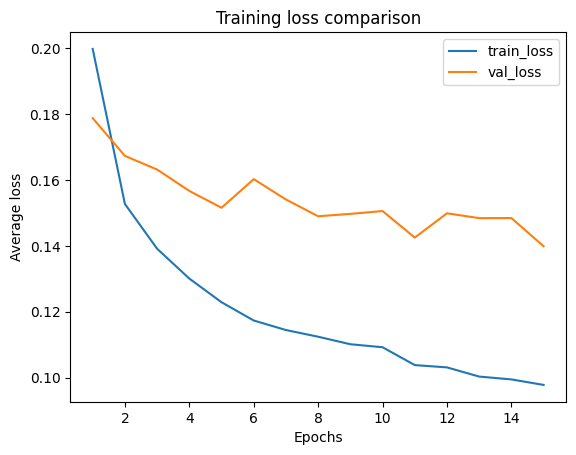

In [18]:
ep = range(1,len(case_1_train_loss)+1)

plt.plot(ep, case_1_train_loss, label = 'train_loss')
plt.plot(ep, case_1_val_loss, label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.legend()
plt.title('Training loss comparison')
plt.show()

Save the model for later.

In [19]:
torch.save(model, "/home/ubuntu/models/sam_experiments/topo-no-reg-lambda-0.1_geom-int150_box-prompt.pth")

Load the saved model if necessary to train further.

In [15]:
model = torch.load("/home/ubuntu/models/sam_experiments/topo-no-reg-lambda-0.1_geom-int150_box-prompt_ep-12.pth")
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

The best model for this configuration has been in epoch 14, and we have saved it in `"/home/ubuntu/models/sam_experiments/topo-no-reg_geom-int150_box-prompt.pth"`.

### SAM trained with Topological loss (without regularisation) with interpolation of 50, geometrical loss with interpolation of 150 and point prompt

The training takes around 32min per epoch. Weight decay was `weight_decay = 1e-5` and learning rate was `lr = 1e-4`. We have used batch size 1.

Right we have trained the model for 15 epochs, and the best one was the 12th.

Let us plot the results.

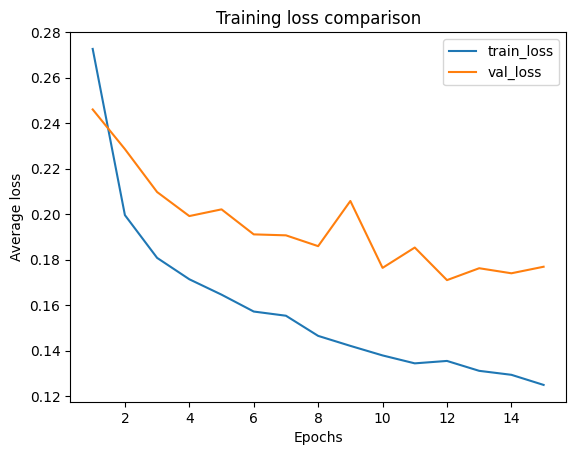

In [13]:
ep = range(1,len(case_2_train_loss)+1)

plt.plot(ep, case_2_train_loss, label = 'train_loss')
plt.plot(ep, case_2_val_loss, label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.legend()
plt.title('Training loss comparison')
plt.show()

Save the model for later.

In [14]:
torch.save(model, "/home/ubuntu/models/sam_experiments/topo-no-reg_geom-int150_point-prompt_ep-15.pth")

Load the train model if necessary to train further.

In [10]:
model = torch.load("/home/ubuntu/models/sam_experiments/topo-no-reg_geom-int150_point-prompt_ep-14.pth")
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

The best model for this configuration has been in epoch 12, and we have saved it in `"/home/ubuntu/models/sam_experiments/topo-no-reg_geom-int150_point-prompt.pth"`.

### SAM trained without Topological loss, geometrical loss with interpolation of 150 and box prompt

The training takes around 27min per epoch. Weight decay was `weight_decay = 1e-4` and learning rate was `lr = 1e-5`. We have used batch size 1.

Right we have trained the model for 15 epochs, and the best one was the 10th.

Let us plot the results.

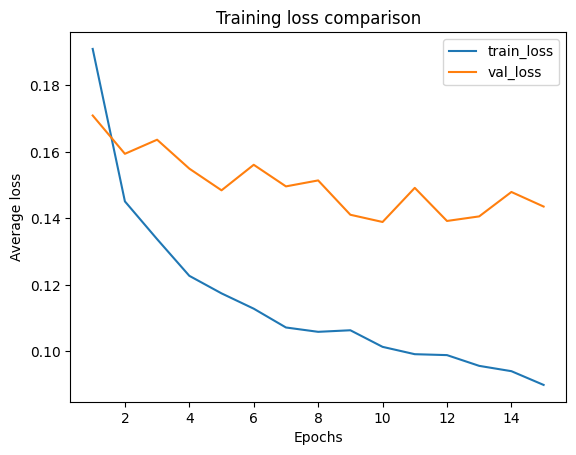

In [26]:
ep = range(1,len(case_3_train_loss)+1)

plt.plot(ep, case_3_train_loss, label = 'train_loss')
plt.plot(ep, case_3_val_loss, label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.legend()
plt.title('Training loss comparison')
plt.show()

Save the model for later.

In [27]:
torch.save(model, "/home/ubuntu/models/sam_experiments/no-topo_geom-int150_box-prompt_ep-15.pth")

Load the train model if necessary to train further.

In [11]:
model = torch.load("/home/ubuntu/models/sam_experiments/no-topo_geom-int150_box-prompt_ep-9.pth")
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

### SAM trained without Topological loss, geometrical loss with interpolation of 150 and point prompt

The training takes around 27min per epoch. Weight decay was `weight_decay = 1e-4` and learning rate was `lr = 1e-5`. We have used batch size 1.

Right we have trained the model for 15 epochs, and the best one was the 15th.

Let us plot the results.

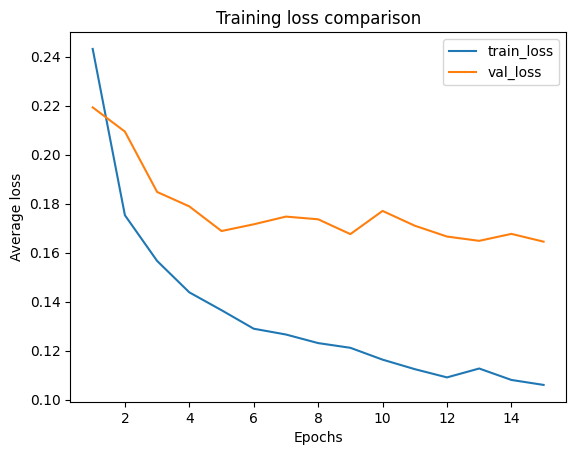

In [17]:
ep = range(1,len(case_4_train_loss)+1)

plt.plot(ep, case_4_train_loss, label = 'train_loss')
plt.plot(ep, case_4_val_loss, label = 'val_loss')

plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.legend()
plt.title('Training loss comparison')
plt.show()

Save the model for later.

In [19]:
torch.save(model, "/home/ubuntu/models/sam_experiments/no-topo_geom-int150_point-prompt.pth")

Load the train model if necessary to train further.

In [10]:
model = torch.load("/home/ubuntu/models/sam_experiments/no-topo_geom-int150_point-prompt_ep-11.pth")
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

# Metrics on test dataset

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

First we will load the test dataset from the small subset of the total dataset.

In [2]:
ds = load_dataset('json', data_files='/home/ubuntu/data/small_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)
print(f'Length of test dataset:', len(test_dataset))

Length of test dataset: 379


Convert to a SAM dataset class.

In [3]:
from utils.sam_dataset import SAMDataset
from transformers import SamProcessor
# Define dataset location folder
data_folder = "/home/ubuntu/data/"
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)

## Load models

We load all the models trained before.
* Model 1: SAM trained with topological and geometrical loss with box prompt
* Model 2: SAM trained with topological and geometrical loss with point prompt
* Model 3: SAM trained with geometrical loss with box prompt
* Model 4: SAM trained with geometrical loss with point prompt

In [4]:
model_1 = torch.load("/home/ubuntu/models/sam_experiments/topo-no-reg_geom-int150_box-prompt.pth")
for name, param in model_1.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

model_2 = torch.load("/home/ubuntu/models/sam_experiments/topo-no-reg_geom-int150_point-prompt.pth")
for name, param in model_2.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

model_3 = torch.load("/home/ubuntu/models/sam_experiments/no-topo_geom-int150_box-prompt.pth")
for name, param in model_3.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

model_4 = torch.load("/home/ubuntu/models/sam_experiments/no-topo_geom-int150_point-prompt.pth")
for name, param in model_4.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Compute the metrics for every model

Given a model and a dataloader this function returns a dictionary with all the metrics for that model.

We will compute many different metrics for every model:
| Metric     | Definition |
| ----- | ---------- |
| Intersection over Union `IoU`   | Formula = Intersection / Union |
| Dice Square Coefficient `DSC` | Formula: Dice = (2 * Intersection) / (Sum of squares of the masks' areas) |
| Surface Distance `SurfDist` | Recently discovered by Deepmind |
| Sensitivity `Sens` | Formula: Sensitivity = True Positives / (True Positives + False Negatives) |
| Specificity `Spec` | Formula: Specificity = True Negatives / (True Negatives + False Positives) |
| Hausdorff Distance `HausDist` | Quantifies the maximum distance between the contours of the predicted and ground truth masks |
| Average Precision `AP` | Computed by integrating the precision-recall curve |
| F1 Score `F1` | Formula: F1 Score = 2 * (Precision * Recall) / (Precision + Recall) |

In [7]:
import torch.nn.functional as F
from utils.metrics import iou, dsc, surfdist, sensitivity, specificity, hausdorff_dist, ap, f1_score
from statistics import mean
def metrics_calculation(model, test_dataloader, prompt, device):
    """
    Compute all the metrics above for one model on a given dataset.

    Args:
        model (transformers.model): model to use
        test_dataloader (torch.utils.data.dataloader.DataLoader): dataloader for the test dataset
        prompt (string): "box" or "point" depending on how we want to do the inference
        device (string): device where we work

    Returns:
        metrics_dict (dictionary): dictionary containing all array with metrics for every image
    """
    iou_values = []
    dsc_values = []
    surfdist_values = []
    sens_values = []
    spec_values = []
    hausdist_values = []
    ap_values = []
    f1_values = []

    # Set model to device
    model.to(device)
    # Set evaluation mode
    model.eval()

    # Run on all batches
    for batch in test_dataloader:
        # Get ground-truth masks
        ground_truth_masks = batch["ground_truth_mask"].float().unsqueeze(1).to(device)
        _, _, m_h, m_w = ground_truth_masks.shape
            
        # Do not compute gradients anywhere
        with torch.no_grad():
        # Forward pass
            if prompt == "point":
                outputs = model(pixel_values=batch["pixel_values"].to(device),
                                input_points=batch["input_points"].to(device),
                                multimask_output=False)
            elif prompt == "box":
                outputs = model(pixel_values=batch["pixel_values"].to(device),
                                input_boxes=batch["input_boxes"].to(device),
                                multimask_output=False)
        # Get masks
        predicted_masks = outputs.pred_masks.to(device)
        # Masks post processing
        predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                        mode="bilinear", align_corners=False)
        predicted_masks = predicted_masks[..., :992, :1024]
        predicted_masks = F.interpolate(predicted_masks, (m_h, m_w), 
                                        mode="bilinear", align_corners=False)
        
        # Apply sigmoid
        predicted_masks = torch.sigmoid(predicted_masks)

        # Compute metrics
        iou_values.append(iou(predicted_masks, ground_truth_masks))
        dsc_values.append(dsc(predicted_masks, ground_truth_masks))
        surfdist_values.append(surfdist(predicted_masks, ground_truth_masks))
        sens_values.append(sensitivity(predicted_masks, ground_truth_masks))
        spec_values.append(specificity(predicted_masks, ground_truth_masks))
        hausdist_values.append(hausdorff_dist(predicted_masks, ground_truth_masks))
        ap_values.append(ap(predicted_masks, ground_truth_masks))
        f1_values.append(f1_score(predicted_masks, ground_truth_masks))
    
    # Create dictionary with all values
    metrics_dict = {}
    metrics_dict["IoU"] = mean(iou_values)
    metrics_dict["DSC"] = mean(dsc_values)
    metrics_dict["SurfDist"] = mean(surfdist_values)
    metrics_dict["Sens"] = mean(sens_values)
    metrics_dict["Spec"] = mean(spec_values)
    metrics_dict["HausDist"] = mean(hausdist_values)
    metrics_dict["AP"] = mean(ap_values)
    metrics_dict["F1"] = mean(f1_values)

    return metrics_dict


In [8]:
import torch.utils.data as DataLoader

# Create dataloader for the dataset
sam_test_dataloader = DataLoader.DataLoader(sam_test_dataset, batch_size=1, shuffle=True)
device = "cuda"

# Compute metrics
metrics_model_1 = metrics_calculation(model = model_1.to(device), test_dataloader=sam_test_dataloader, prompt = "box", device = "cuda")
metrics_model_2 = metrics_calculation(model = model_2.to(device), test_dataloader=sam_test_dataloader, prompt = "point", device = "cuda")
metrics_model_3 = metrics_calculation(model = model_3.to(device), test_dataloader=sam_test_dataloader, prompt = "box", device = "cuda")
metrics_model_4 = metrics_calculation(model = model_4.to(device), test_dataloader=sam_test_dataloader, prompt = "point", device = "cuda")


/home/ubuntu/venv/lib/python3.10/site-packages/monai/metrics/utils.py:338: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


### Save the results.

We will save the results on a `results.csv` that can be later used to compare the models.

In [9]:
import pandas as pd

# Save information in lists
models_list = ["SAM trained with Topo. + Geom. Loss and box prompt",
               "SAM trained with Topo. + Geom. Loss and point prompt",
               "SAM trained with Geom. Loss and box prompt",
               "SAM trained with Geom. Loss and point prompt"]
iou_list = [metrics_model_1["IoU"], metrics_model_2["IoU"], metrics_model_3["IoU"], metrics_model_4["IoU"]]
dsc_list = [metrics_model_1["DSC"], metrics_model_2["DSC"], metrics_model_3["DSC"], metrics_model_4["DSC"]]
surfdist_list = [metrics_model_1["SurfDist"], metrics_model_2["SurfDist"], metrics_model_3["SurfDist"], metrics_model_4["SurfDist"]]
sens_list = [metrics_model_1["Sens"], metrics_model_2["Sens"], metrics_model_3["Sens"], metrics_model_4["Sens"]]
spec_list = [metrics_model_1["Spec"], metrics_model_2["Spec"], metrics_model_3["Spec"], metrics_model_4["Spec"]]
hausdist_list = [metrics_model_1["HausDist"], metrics_model_2["HausDist"], metrics_model_3["HausDist"], metrics_model_4["HausDist"]]
ap_list = [metrics_model_1["AP"], metrics_model_2["AP"], metrics_model_3["AP"], metrics_model_4["AP"]]
f1_list = [metrics_model_1["F1"], metrics_model_2["F1"], metrics_model_3["F1"], metrics_model_4["F1"]]

# Save dataframe and later to .csv
df = pd.DataFrame(list(zip(models_list, iou_list, dsc_list, surfdist_list,
                           sens_list, spec_list, hausdist_list, ap_list, f1_list)),
                           columns =['Model', 'IoU', 'DSC', 'Surface Distance', 'Sensitivity', 'Specificity',
                                     'Hausdorff Distance', 'AP', 'F1'])

df.to_csv("/home/ubuntu/models_metrics.csv")